In [1]:
# ML_in_Finance-Deep-Factor-Models
# Author: Matthew Dixon
# Version: 1.0 (24.7.2019)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X with Python 3.6 and Tensorflow 1.3.0
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Dixon M.F., I. Halperin and P. Bilokon, Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 

# Overview

In [20]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.regularizers import l1,l2
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
#from utilities import *
#from view import *
import timeit
import statsmodels.api as sm
import datetime as dt
#from dateutil.relativedelta import *

# comment these if running python instead of ipython
%load_ext autoreload
%matplotlib inline 
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define a deep neural network (with L-1 hidden layers) model in Keras

In [7]:
def NN(n_inputs, n_units=10, dropout=0.1, l1_reg=0.001, activation='relu', L=2):
    # L>0 is the number of hidden layers
    
    model = Sequential()
    model.add(Dense(units=n_units, input_dim=n_inputs, kernel_regularizer=l1(l1_reg), kernel_initializer='normal', activation=activation))
    model.add(Dropout(dropout))
    for i in range (0, L-1):
        model.add(Dense(units=n_units, kernel_regularizer=l1(l1_reg), kernel_initializer='normal', activation=activation))
        model.add(Dropout(dropout))
    model.add(Dense(1, kernel_initializer='normal')) 
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return(model)

In [8]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)

In [9]:
def parameter_tuning(X, y, cv=3, n_epoches=100, n_batch=10, seed=7):
    param_grid = dict(n_inputs=[X.shape[1]], n_units=[10, 20, 50], 
                      l1_reg = [0, 0.0001, 0.001], activation=['relu','tanh']) 
    estimator = KerasRegressor(build_fn=NN, epochs=n_epoches, batch_size=n_batch, verbose=0)   
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, 
                        cv=cv, fit_params=dict(callbacks=[es]))
    grid_result = grid.fit(X, y)
  
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [10]:
def training(X, Y, training_dates, L, tune=False):
 
    n_epoches = 100  # maximum number of epoches (to be used with early stopping)
    n_batch = 10     # mini-batch size
    drop_out = 0.0   # level of dropout (set between 0 and 1)
    n_units = 10
    l1_reg = 0.001   # L_1 regularization parameter
    activation ='tanh'
    models = {}
    xs = {}
    ys = {}
    
    models = {}
    models['linear'] = []
    models['NN'] = []
    xs = {}
    ys = {}

    xs['train'] = []
    xs['test'] = []
    ys['train'] = []
    ys['test'] = []
    
    betas = {}
    betas['NN'] = []
    betas['linear'] = []

    i = 0
    for date in training_dates:
        start_time = timeit.default_timer()  
        print(i, date)
        train_index = X[X['date'] == date].index
        
        if len(train_index) == 0:
            next
        date_next = pd.Timestamp(np.datetime64(date)).to_pydatetime() + relativedelta(months=+1)
        date_next = date_next.strftime('%Y-%m-%d')
        test_index  = X[X['date'] == date_next].index
        if len(test_index) == 0:
            next

        x_train = X.loc[train_index]
        x_train = x_train.drop("date", axis=1)
        y_train = Y.loc[train_index]
        y_train= y_train.drop("date", axis=1)
        x_test = X.loc[test_index]
        x_test = x_test.drop("date", axis=1)
        y_test = Y.loc[test_index]
        y_test = y_test.drop("date", axis=1)
        

        n_inputs = x_train.shape[1]
        if n_inputs == 0:
            next
       
        if tune: # just perform parameter tuning once
            print("Parameter tuning with X-validation...")      
            parameter_tuning(x_train, y_train, 3)
            tune = False

        model = NN(n_units=n_units, n_inputs=n_inputs, dropout=drop_out, l1_reg=l1_reg, activation=activation, L=L)
        model.fit(x_train.values, y_train.values, epochs=n_epoches, batch_size=n_batch, verbose=0, callbacks=[es])   
        beta=sensitivities(model, x_train.values, L, activation)   
        models['NN'].append(model)
        betas['NN'].append(beta)
        x = sm.add_constant(x_train)
        model = sm.OLS(y_train, x).fit()   
        betas['linear'].append(model.params)
        models['linear'].append(model)
        xs['train'].append(x_train)
        xs['test'].append(x_test)
        ys['train'].append(y_train)
        ys['test'].append(y_test)

        elapsed = timeit.default_timer() - start_time
        print("Elapsed time:" + str(elapsed) + " (s)")
        i += 1
        
    return models, betas, xs, ys

In [14]:
# Compute the feature sensitivities in the deep network. Assume that the activation function is either tanh or relu.
def sensitivities(lm, X, L, activation='tanh'):
    
    W = lm.get_weights()
    M = np.shape(X)[0]
    p = np.shape(X)[1]
    beta = np.array([0]*M*(p+1), dtype='float32').reshape(M, p+1)
    B_0 = W[1]
    for i in range (0, L):
        if activation == 'tanh':  
            B_0 = (np.dot(np.transpose(W[2*(i+1)]),np.tanh(B_0)) + W[2*(i+1)+1])
        elif activation == 'relu':
            B_0 = (np.dot(np.transpose(W[2*(i+1)]),np.maximum(B_0, 0)) + W[2*(i+1)+1])
    beta[:,0]= B_0 # intercept \beta_0 = F_{W,b}(0)
    for i in range(M):
        I1 = np.dot(np.transpose(W[0]), np.transpose(X[i,])) + W[1]
        if activation == 'tanh':
            Z= np.tanh(I1)  
            D = np.diag(1-Z**2)
        elif activation == 'relu':
            Z=np.maximum(I1, 0)
            D = np.diag(np.sign(Z)) 
                 
        for j in range(p):
            J = np.dot(D,W[0][j])       
            for a in range (1, L):
                I= np.dot(np.transpose(W[2*a]),Z) + W[2*a+1] 
                if activation == 'tanh':  
                    Z = np.tanh(I)
                    D = np.diag(1-Z**2)
                elif activation == 'relu':    
                    Z = np.maximum(I,0)
                    D = np.diag(np.sign(Z)) 
                J = np.dot(np.dot(D,np.transpose(W[a*2])), J)
            beta[i, j+1]=np.dot(np.transpose(W[2*L]), J)
    return(beta)

In [15]:
# Load the data
X = pd.read_csv('../data/X_small.csv') # factor exposures
Y = pd.read_csv('../data/Y_small.csv') # asset returns

## Training of models 
A new cross-sectional neural network model is fitted in each period. To evalute the performance of strategies, we need to train a model for each time step over an historical period. 

In [21]:
training_periods = 100
L = 2 # number of hidden and output layers
dates = np.unique(X['date'])[0:training_periods] 
models, betas, xs, ys = training(X, Y, dates, L, False) # Set last argument to True to perform cross-validation for parameter tuning

0 2008-02-01
Epoch 00010: early stopping
Elapsed time:2.9870083590012655 (s)
1 2008-03-01
Epoch 00014: early stopping
Elapsed time:2.9381871950008644 (s)
2 2008-04-01
Epoch 00020: early stopping
Elapsed time:3.079695902999447 (s)
3 2008-05-01
Epoch 00013: early stopping
Elapsed time:3.3978081839995866 (s)
4 2008-06-01
Epoch 00012: early stopping
Elapsed time:2.616081137999572 (s)
5 2008-07-01
Epoch 00015: early stopping
Elapsed time:3.5207968300001085 (s)
6 2008-08-01
Epoch 00013: early stopping
Elapsed time:3.433424308001122 (s)
7 2008-09-01
Epoch 00014: early stopping
Elapsed time:3.352003722000518 (s)
8 2008-10-01
Epoch 00032: early stopping
Elapsed time:4.782347235999623 (s)
9 2008-11-01
Epoch 00051: early stopping
Elapsed time:5.810526877001394 (s)
10 2008-12-01
Epoch 00037: early stopping
Elapsed time:4.8374149369992665 (s)
11 2009-01-01
Epoch 00037: early stopping
Elapsed time:5.118614552000508 (s)
12 2009-02-01
Epoch 00014: early stopping
Elapsed time:3.320735957000579 (s)
13 2

# Performance evaluation

We note, for this small dataset, that the difference in the MSEs between OLS and neural networks is marginal, however, the L_inf norms are substantially different, indicating the superior ability of the neural network to capture outliers. 

In [25]:
# Evaluate MSE of OLS out-of-sample
MSE = 0
y_hat_linear = []
MSE_array_linear = np.array([0]*training_periods, dtype='float64')
for i in range(training_periods):
    x = sm.add_constant(xs['test'][i].values)
    y_hat_linear.append(models['linear'][i].predict(x))
    MSE_test_linear = mean_squared_error(y_hat_linear[-1], ys['test'][i].values)
    MSE_array_linear[i]=MSE_test_linear
    MSE += MSE_test_linear
print("MSE: " + str(MSE / training_periods))    

MSE:0.017511483871247034


In [26]:
# Evaluate MSE of OLS in-sample
MSE = 0
MSE_array_linear_in = np.array([0]*training_periods, dtype='float64')
y_hat_linear_is = []
for i in range(training_periods):
    x = sm.add_constant(xs['train'][i].values)
    y_hat_linear_is.append(models['linear'][i].predict(x))
    MSE_test_linear = mean_squared_error(y_hat_linear_is[-1], ys['train'][i].values)
    #print(i,MSE_test_linear)
    MSE_array_linear_in[i] = MSE_test_linear
    MSE += MSE_test_linear
print("MSE: " + str(MSE / training_periods))    

MSE:0.004573922402548681


In [27]:
# Evaluate L_inf norm of OLS out-of-sample
inf_norm = 0
y_hat_linear = []
inf_norm_linear_out = np.array([0]*training_periods, dtype='float64')
for i in range(training_periods):
    x = sm.add_constant(xs['test'][i].values)
    y_hat_linear.append(models['linear'][i].predict(x))
    inf_norm_linear = np.max(np.abs(y_hat_linear[-1] - ys['test'][i].values))
    inf_norm_linear_out[i] = inf_norm_linear
    inf_norm += inf_norm_linear
print("inf-norm: " + str(inf_norm / training_periods))   

inf-norm:0.5148467207968435


In [29]:
# Evaluate L_inf norm of OLS in-sample
inf_norm = 0
y_hat_linear = []
inf_norm_linear_in = np.array([0]*training_periods, dtype='float64')
for i in range(training_periods):
    x = sm.add_constant(xs['train'][i].values)
    y_hat_linear.append(models['linear'][i].predict(x))
    inf_norm_linear = np.max(np.abs(y_hat_linear[-1] - ys['train'][i].values))
    inf_norm_linear_in[i] = inf_norm_linear
    inf_norm += inf_norm_linear
print("inf-norm: " + str(inf_norm/training_periods)) 

inf-norm:0.4225199869563092


In [31]:
# Evaluate MSE of NN out-of-sample
MSE = 0
MSE_array_NN = np.array([0]*training_periods, dtype='float64')
y_hat_NN=[]
for i in range(training_periods):
    y_hat_NN.append(models['NN'][i].predict(xs['test'][i].values))
    MSE_test_NN = mean_squared_error(y_hat_NN[-1], ys['test'][i].values)
    MSE_array_NN[i] = MSE_test_NN
    MSE += MSE_test_NN
print("MSE: " + str(MSE / training_periods))  

MSE: 0.01686421947031692


In [32]:
# Evaluate MSE of NN in-sample
MSE = 0
MSE_array_NN_in = np.array([0]*training_periods, dtype='float64')
y_hat_NN_is = []
for i in range(training_periods):
    y_hat_NN_is.append(models['NN'][i].predict(xs['train'][i].values))
    MSE_test_NN = mean_squared_error(y_hat_NN_is[-1], ys['train'][i].values)
    MSE_array_NN_in[i] = MSE_test_NN
    MSE += MSE_test_NN
print("MSE: " + str(MSE / training_periods)) 

MSE: 0.0050663190305687104


In [33]:
# Evaluate L_\inf norm of NN out-of-sample
inf_norm = 0
inf_norm_test_NN = np.array([0]*training_periods, dtype='float64')
y_hat_NN = []
for i in range(training_periods):
    y_hat_NN.append(models['NN'][i].predict(xs['test'][i].values))
    inf_norm_NN = np.max(np.abs(y_hat_NN[-1] - ys['test'][i].values))
    inf_norm_test_NN[i] = inf_norm_NN
    inf_norm += inf_norm_NN
print("inf-norm: " + str(inf_norm/training_periods))  

inf-norm: 0.3842394744561835


In [34]:
# Evaluate L_\inf norm of NN in-sample
inf_norm = 0
inf_norm_train_NN = np.array([0]*training_periods, dtype='float64')
y_hat_NN_is = []
for i in range(training_periods):
    y_hat_NN_is.append(models['NN'][i].predict(xs['train'][i].values))
    inf_norm_NN = np.max(np.abs(y_hat_NN_is[-1]- ys['train'][i].values))
    inf_norm_train_NN[i] = inf_norm_NN
    inf_norm += inf_norm_NN
print("inf-norm: " + str(inf_norm/training_periods))  

inf-norm: 0.3307378804108776


### L_2 norms

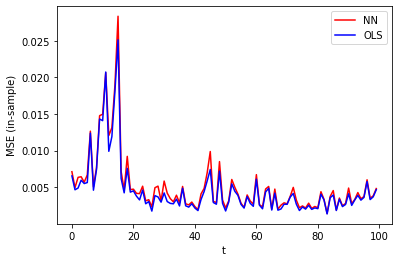

In [35]:
plt.plot(MSE_array_NN_in, color='red', label='NN')
#plt.yscale('log')
plt.plot(MSE_array_linear_in, color='blue', label='OLS')
plt.ylabel('MSE (in-sample)')
plt.xlabel('t')
plt.legend();

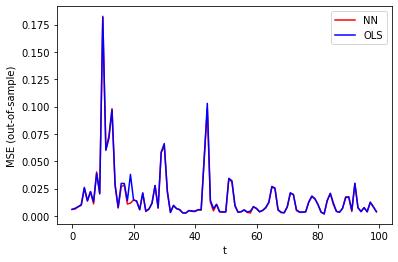

In [36]:
plt.plot(MSE_array_NN, color='red', label='NN')
#plt.yscale('log')
plt.plot(MSE_array_linear, color='blue', label='OLS')
plt.ylabel('MSE (out-of-sample)')
plt.xlabel('t')
plt.legend();

### L-inf norms 

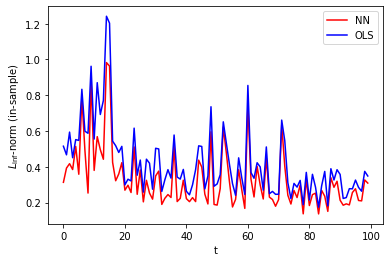

In [37]:
plt.plot(inf_norm_train_NN, color='red', label='NN')
#plt.yscale('log')
plt.plot(inf_norm_linear_in, color='blue', label='OLS')
plt.ylabel('$L_{\inf}$-norm (in-sample)')
plt.xlabel('t')
plt.legend();

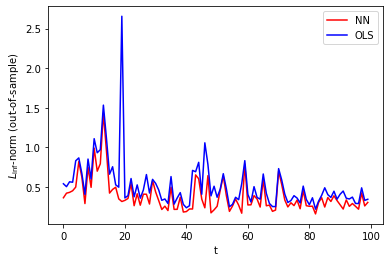

In [38]:
plt.plot(inf_norm_test_NN, color='red', label='NN')
#plt.yscale('log')
plt.plot(inf_norm_linear_out, color='blue', label='OLS')
plt.ylabel('$L_\inf$-norm (out-of-sample)')
plt.xlabel('t')
plt.legend();

# Sensitivities
Plot the sensitivies of the neural network to the input factors and compare with OLS regression.

In [39]:
betas['NN'][i][0][1:]

array([ 5.6658482e-09, -1.2416294e-09,  1.5227359e-08,  7.3150965e-09,
        1.4794617e-09,  1.0066771e-08], dtype=float32)

In [40]:
n_var = np.shape(betas['NN'][1])[1] - 1
print(n_var)

mu = np.array([0]*training_periods*n_var, dtype='float32').reshape(training_periods, n_var)
sd = np.array([0]*training_periods*n_var, dtype='float32').reshape(training_periods, n_var)
mu_ols = np.array([0]*training_periods*n_var, dtype='float32').reshape(training_periods, n_var)

for i in range(training_periods):
    mu[i,:] = np.median(betas['NN'][i], axis=0)[1:]
    sd[i,:] = np.std(betas['NN'][i], axis=0) [1:]
    mu_ols[i,:] = betas['linear'][i][1:]

6


In [42]:
names = ['EV', 'P/B', 'EV/T12M EBITDA', 'P/S' , 'P/E','Log CAP']

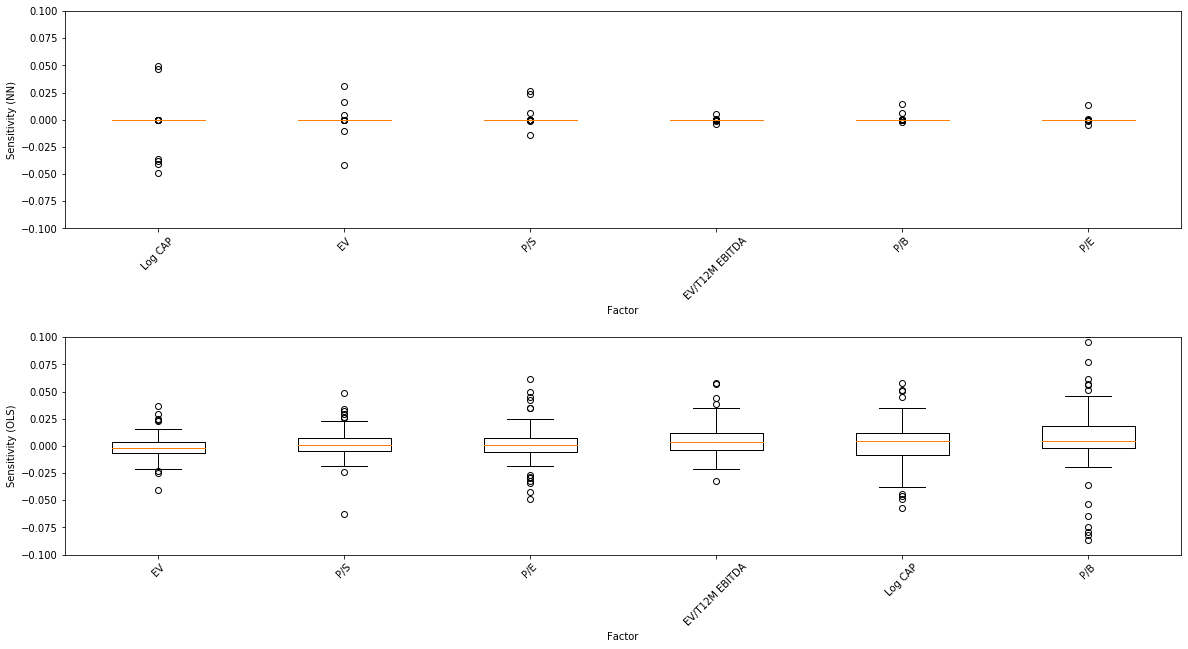

In [43]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.7)
%sc = 10000
idx=np.argsort(np.median(mu[:, 0:n_var], axis=0))
axes[0].boxplot(mu[:, idx])       # make your boxplot
axes[0].set_xticklabels(np.array(names)[idx],rotation=45)  
axes[0].set_ylim([-0.1, 0.1])
axes[0].set_ylabel('Sensitivity (NN)')
axes[0].set_xlabel('Factor')
idx=np.argsort(np.median(mu_ols[:, 0:n_var], axis=0))
axes[1].boxplot(mu_ols[:, idx]) 
axes[1].set_ylim([-0.1, 0.1])
axes[1].set_xticklabels(np.array(names)[idx], rotation=45) 

axes[1].set_ylabel('Sensitivity (OLS)')
axes[1].set_xlabel('Factor');

The above sensitivities are sorted in ascending order from left to right. We observe that the OLS regression is much more sensitive to the factors than the NN.